# Linear time-invariant system

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal as sig

%matplotlib inline

In [2]:
def plot(x, y):
    plt.plot(x,y)
    plt.grid()
    plt.axhline(0, c='black')
    plt.axvline(0, c='black')

## Transfer function representation

$$ A_n(\frac{d}{dt})x = B_m(\frac{d}{dt})y $$

$$ \mathcal{L}[f(t)] = \int\limits_0^{\infty} f(t) e^{-st} dt $$

$$ \mathcal{L}[A_n(\frac{d}{dt})x] = \mathcal{L}[B_m(\frac{d}{dt})y] $$

$$ A_n(s)X = B_m(s)Y $$

$$ H(s) = \frac{A_n(s)}{B_m(s)} \Rightarrow Y = HX $$

In [3]:
numerator = np.array([1,-1,1,-1])
denominator_un = np.array([1,0,1,4])
denominator_st = np.array([1,5,1,4])

Loop in system

$$ Y = kG(G_2Y \circ X) $$
$$ Y(1 (\circ^{-1}) kG_2G) = kGX $$
$$ Y = \frac{kG}{1 (\circ^{-1}) kG_2G}X $$

$$ G = \frac{A}{B} \Rightarrow Y =  \frac{kA}{B (\circ^{-1}) kG_2A} X $$

where $\circ$ - some operation, $(\circ)^{-1}$ - inverse operation

For example, if $\circ$ is minus, $G_2 = 1$:

$$ Y = \frac{kA}{B + kA} $$

In [4]:
def add_loop(numerator, denominator, k):
    return (k*numerator, denominator - k*numerator)

def sub_loop(numerator, denominator, k):
    return (k*numerator, denominator + k*numerator)

In [5]:
print(f"Physical implementability:  {numerator.shape[0] <= denominator_st.shape[0]}")

Physical implementability:  True


## ZPK representation

$$ A_n(z_i) = 0 \;\;\; B_m(p_i) = 0 $$

$$ H(s) = k \frac{\prod\limits_{i=1}^{n}(s-z_i)}{\prod\limits_{j=1}^{m}(s-p_j)} $$

### Unstable system

In [6]:
z,p,k = sig.tf2zpk(numerator, denominator_un)

In [7]:
def print_zpk(z, p, k):
    print(f"Zeros: {np.round(z, 2)}")
    print(f"Poles: {np.round(p, 2)}")
    print(f"Koeff: {k}")

    print(f"System stability: {~np.any(p.real > 0)}")

In [8]:
print_zpk(z, p, k)

Zeros: [1.+0.j 0.+1.j 0.-1.j]
Poles: [ 0.69+1.56j  0.69-1.56j -1.38+0.j  ]
Koeff: 1.0
System stability: False


Text(0.5, 1.0, 'Step response')

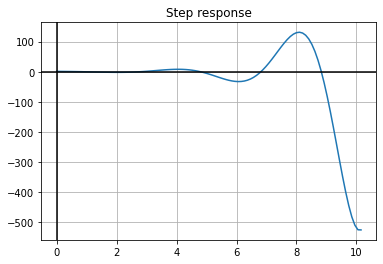

In [9]:
t,y = sig.step((numerator, denominator_un))

plot(t, y)
plt.title("Step response")

Text(0.5, 1.0, 'Impulse response')

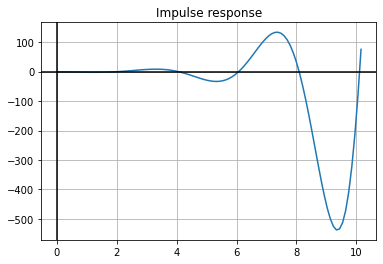

In [10]:
t,y = sig.impulse((numerator, denominator_un))

plot(t, y)
plt.title("Impulse response")

### Stable system

In [11]:
z,p,k = sig.tf2zpk(numerator, denominator_st)

Text(0.5, 1.0, 'Step response')

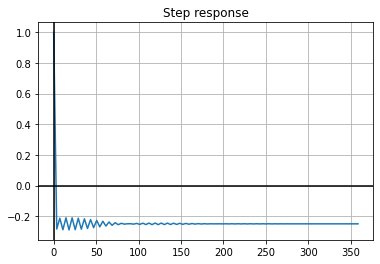

In [12]:
t,y = sig.step((numerator, denominator_st))

plot(t, y)
plt.title("Step response")

Text(0.5, 1.0, 'Impulse response')

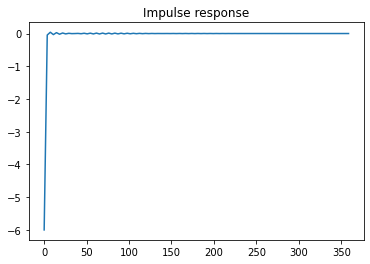

In [13]:
t,y = sig.impulse((numerator, denominator_st))

plt.plot(t, y)
plt.title("Impulse response")

In [14]:
print_zpk(z, p, k)

Zeros: [1.+0.j 0.+1.j 0.-1.j]
Poles: [-4.96+0.j  -0.02+0.9j -0.02-0.9j]
Koeff: 1.0
System stability: True


In [15]:
#w, nyquist = sig.freqresp((z, p, k))

#plt.plot(z.real, z.imag, 'o')
#plt.plot(p.real, p.imag, 'o')
#plot(nyquist.real, nyquist.imag)

## Space-state representation

$q$ - state variables

$$
\begin{cases}
    \dfrac{dq}{dt} &= \textbf{A}q + \textbf{B}x \\
    y &= \textbf{C}q + \textbf{D}x
\end{cases}
$$

In [16]:
A,B,C,D = sig.zpk2ss(z, p, k)

In [17]:
#func only for single input
def observable(A,B,C,D):    
    T = np.empty_like(A) #Tinv
    for i in range(A.shape[0]):
        T[i, :] = (np.linalg.matrix_power(A, i).T @ C.T).reshape(A.shape[0])    
    
    An = T @ A @ np.linalg.inv(T)
    Bn = T @ B
    Cn = C @ np.linalg.inv(T)    
    return An, Bn, Cn, D

def controlable(A,B, C, D):
    T = np.empty_like(A)
    for i in range(A.shape[0]):
        T[:, i] = (np.linalg.matrix_power(A, i) @ B).reshape(A.shape[0])    
        
    An = np.linalg.inv(T) @ A @ T
    Bn = np.linalg.inv(T) @ B
    Cn = C @ T
    return An, Bn, Cn, D

In [18]:
print("Observable canonical form")
print(np.round(observable(A, B, C, D)[0], 3))

Observable canonical form
[[ 0.  1. -0.]
 [ 0. -0.  1.]
 [-4. -1. -5.]]


In [19]:
print("Controlable canonical form")
print(np.round(controlable(A, B, C, D)[0], 3))

Controlable canonical form
[[ 0.  0. -4.]
 [ 1.  0. -1.]
 [ 0.  1. -5.]]


System obsevable if

$$ \mathrm{rank} 
\begin{pmatrix} 
    C \\ 
    CA \\
    CA^2 \\
    \dots \\
    CA^{n-1}
\end{pmatrix} = n$$

System controlable if

$$ \mathrm{rank} 
\begin{pmatrix} 
    B \;
    AB \;
    A^2B \;
    \dots \; 
    A^{n-1}B
\end{pmatrix} = n$$

In [20]:
#func only for single input
def is_observable(A, C):
    T = np.empty_like(A)
    for i in range(A.shape[0]):
        T[:, i] = (C @ np.linalg.matrix_power(A, i)).reshape(A.shape[0])
    return np.linalg.matrix_rank(T) == A.shape[0]

def is_controlable(A, B):
    T = np.empty_like(A)
    for i in range(A.shape[1]):
        T[i, :] = (np.linalg.matrix_power(A, i) @ B).reshape(A.shape[0])
    return np.linalg.matrix_rank(T) == A.shape[0]

In [21]:
print(f"System controlability: {is_controlable(A, B)}")
print(f"System observability: {is_observable(A, C)}")

System controlability: True
System observability: True


### Difference of Step response

In [22]:
numerator2, denominator2 = sig.ss2tf(A,B,C,D)

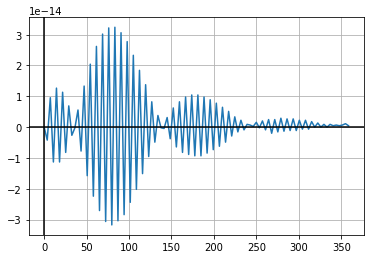

In [23]:
t, y1 = sig.step((numerator, denominator_st))
t, y2 = sig.step((numerator2, denominator2))

plot(t,y1 - y2)

### Difference of Impulse response

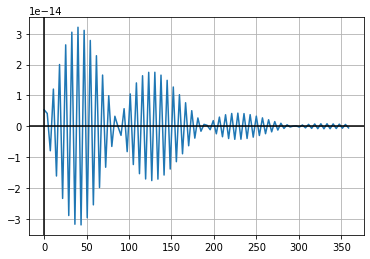

In [24]:
t,y1 = sig.impulse((numerator, denominator_st))
t, y2 = sig.impulse((numerator2, denominator2))

plot(t, y1 - y2)